# Tutorial 5 - Implementing Weinhardt et al. (2024)

In this section we are going to set up the RNN as implemented by *Weinhardt et al (2024)* (https://openreview.net/forum?id=x2WDZrpgmB).

This RNN includes RNN-modules for approximating goal-directed behavior (`x_value_reward`) as well non-goal-directed behavior (`x_value_choice`).

Our synthetic participant has the parameters `beta_choice` and `alpha_choice`, which are handling the non-goal-directed behavior in the form of a choice-perseverance bias.

This choice-perseverance bias makes the participant prefer to repeat previously chosen actions by increasing `x_value_choice` if chosen previously and decreasing if not chosen anymore.

For that we are going to follow these steps:

1. add the new memory-state value `x_value_choice` in `init_values`
2. add new RNN-modules to process `x_value_choice` -> `x_value_choice_chosen` and `x_value_choice_chosen`
3. add a sigmoid activation to the new RNN-modules and a scaling factor for the new value to prevent exploding values
4. adapt the forward-method

    4.1 handle the calls of the new RNN-modules

    4.2 add the updated value `x_value_choice` to the logit

5. adjust the SINDy-configuration accordingly

We are going to keep here the participant-embedding even though we are not going to simulate different agents. We just have to make sure to set the participant-IDs in the dataset to `0`.

## 1. Data generation

First of all we have to generate a dataset with multiple participants. Let's start with two different ones.

We are going generate half the dataset with participant #1 and the other half with participant #2.

In [8]:
import numpy as np
import torch

np.random.seed(42)
torch.manual_seed(42)

In [9]:
from spice.resources.bandits import BanditsDrift, AgentQ, create_dataset
from spice.resources.rnn_utils import DatasetRNN

# Set up the environment
n_actions = 2
sigma = 0.2

environment = BanditsDrift(sigma=sigma, n_actions=n_actions)

# Set up the agent
agent = AgentQ(
    n_actions=n_actions,
    alpha_reward=0.3,
    forget_rate=0.2,
    beta_choice=1.,
    alpha_choice=1.,
)

# Create the dataset
n_trials = 100
n_sessions = 100

dataset, _, _ = create_dataset(
    agent=agent,
    environment=environment,
    n_trials=n_trials,
    n_sessions=n_sessions,
)

# set all participant ids to 0 since this dataset was generated only by one parameterization
dataset.xs[..., -1] = 0

Creating dataset...


100%|██████████| 100/100 [00:00<00:00, 234.75it/s]


## 2. Using the precoded model

First we setup and train the precoded SPICE model and inspect its behavior, before implementing it ourselves.

In [10]:
from spice.estimator import SpiceEstimator
from spice.precoded import Weinhardt2024RNN, WEINHARDT_2024_CONFIG

spice_estimator = SpiceEstimator(
    rnn_class=Weinhardt2024RNN,
    spice_config=WEINHARDT_2024_CONFIG,
    learning_rate=1e-2,
    epochs=1024,
    n_participants=1,
)

spice_estimator.fit(dataset.xs, dataset.ys)

spice_estimator.print_spice_model()


Training the RNN...
Epoch 1024/1024 --- L(Train): 0.4801823; Time: 0.18s; Convergence: 1.29e-04
Maximum number of training epochs reached.


100%|██████████| 1/1 [00:01<00:00,  1.00s/it]

SPICE modules:
(x_learning_rate_reward)[k+1] = 0.359 1
(x_value_reward_not_chosen)[k+1] = 0.093 1 + 0.795 x_value_reward_not_chosen[k]
(x_value_choice_chosen)[k+1] = 1.000 1
(x_value_choice_not_chosen)[k+1] = 0.255 1
beta(x_value_reward) = 2.6273
beta(x_value_choice) = 1.3758


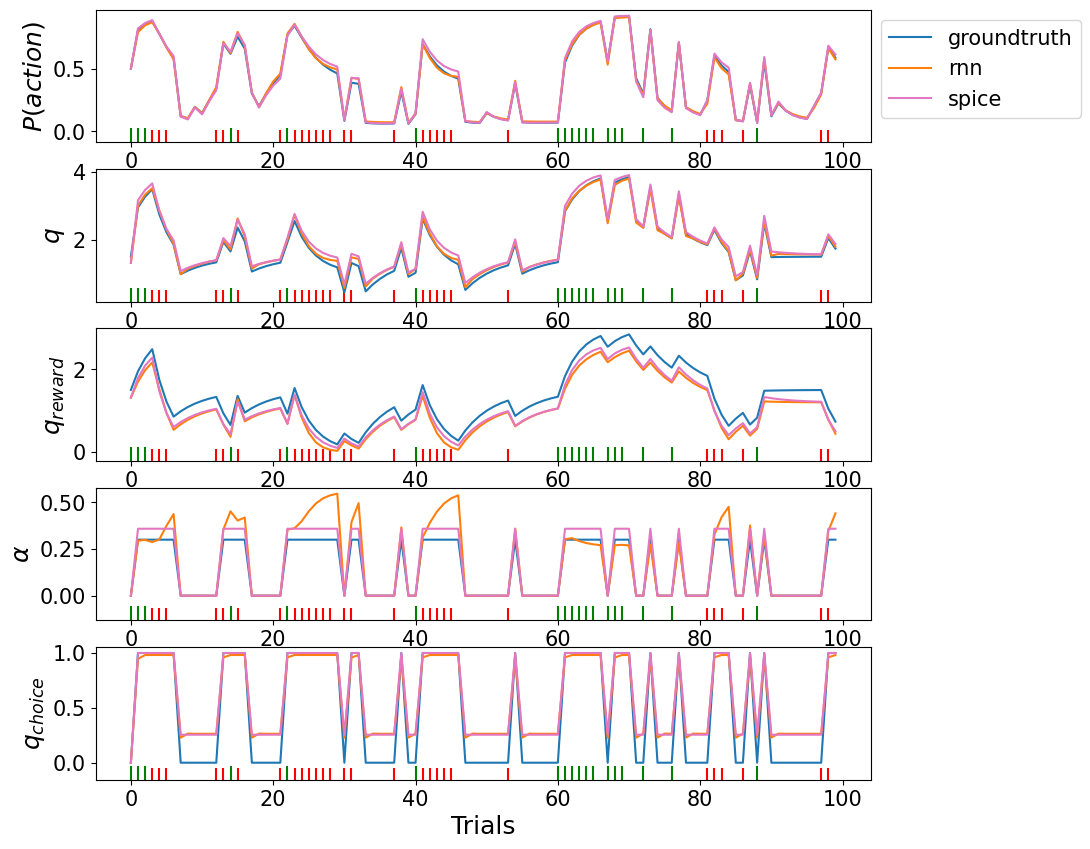

In [11]:
from spice.utils.plotting import plot_session

# Let's see how well the dynamics were fitted
agents = {'groundtruth': agent, 'rnn': spice_estimator.rnn_agent, 'spice': spice_estimator.spice_agent}
fig, axs = plot_session(agents, dataset.xs[0])

## 3. Implementing the RNN from Scratch

Below is the actual implementation of the RNN model by Weinhardt et al. (2024). This RNN includes an additional group of reward-agnostic RNN-modules. These modules update choice-based values of the chosen and non-chosen options.

The structure of this RNN is shown in the following figure:

![](../figures/spice_rnn_weinhardt2024.png)

In [12]:
from spice.estimator import SpiceConfig
from spice.resources.rnn import BaseRNN

custom_config = SpiceConfig(
    rnn_modules=['x_learning_rate_reward', 'x_value_reward_not_chosen', 'x_value_choice_chosen', 'x_value_choice_not_chosen'],
    control_parameters=['c_action', 'c_reward', 'c_value_reward'],
    # The new module which handles the not-chosen value, does not need any additional inputs except for the value
    library_setup = {
        # 'x_value_reward_chosen': ['c_reward'] -> Remove this one from the library as we are not going to identify the dynamics of a hard-coded equation
        'x_learning_rate_reward': ['c_reward', 'c_value_reward'],
        'x_value_reward_not_chosen': [],
        'x_value_choice_chosen': [],
        'x_value_choice_not_chosen': [],
    },

    # Further, the new module should be applied only to the not-chosen values
    filter_setup = {
        # 'x_value_reward_chosen': ['c_action', 1, True], -> Remove this one as well
        'x_learning_rate_reward': ['c_action', 1, True],
        'x_value_reward_not_chosen': ['c_action', 0, True],
        'x_value_choice_chosen': ['c_action', 1, True],
        'x_value_choice_not_chosen': ['c_action', 0, True],
    }    
)

class CustomRNN(BaseRNN):

    init_values = {
            'x_value_reward': 0.5,
            'x_value_choice': 0.,
            'x_learning_rate_reward': 0.,
        }

    def __init__(
        self,
        n_actions,
        n_participants,
        **kwargs,
    ):
        
        super(CustomRNN, self).__init__(n_actions=n_actions, embedding_size=8)
        
        # set up the participant-embedding layer
        self.participant_embedding = self.setup_embedding(num_embeddings=n_participants, embedding_size=self.embedding_size)
        
        # scaling factor (inverse noise temperature) for each participant for the values which are handled by an hard-coded equation
        self.betas['x_value_reward'] = self.setup_constant(embedding_size=self.embedding_size)
        self.betas['x_value_choice'] = self.setup_constant(embedding_size=self.embedding_size)
        
        # set up the submodules
        self.submodules_rnn['x_learning_rate_reward'] = self.setup_module(input_size=2+self.embedding_size)
        self.submodules_rnn['x_value_reward_not_chosen'] = self.setup_module(input_size=0+self.embedding_size)
        self.submodules_rnn['x_value_choice_chosen'] = self.setup_module(input_size=0+self.embedding_size)
        self.submodules_rnn['x_value_choice_not_chosen'] = self.setup_module(input_size=0+self.embedding_size)
        
        # set up hard-coded equations
        self.submodules_eq['x_value_reward_chosen'] = lambda value, inputs: value + inputs[..., 1] * (inputs[..., 0] - value)
        
    def forward(self, inputs, prev_state=None, batch_first=False):
        """Forward pass of the RNN

        Args:
            inputs (torch.Tensor): includes all necessary inputs (action, reward, participant id) to the RNN to let it compute the next action
            prev_state (Tuple[torch.Tensor], optional): That's the previous memory state of the RNN containing the reward-based value. Defaults to None.
            batch_first (bool, optional): Indicates whether the first dimension of inputs is batch (True) or timesteps (False). Defaults to False.
        """
        
        # First, we have to initialize all the inputs and outputs (i.e. logits)
        inputs, ids, logits, timesteps = self.init_forward_pass(inputs, prev_state, batch_first)
        actions, rewards, _, _ = inputs
        participant_id, _ = ids
        
        # Here we compute now the participant embeddings for each entry in the batch
        participant_embedding = self.participant_embedding(participant_id[:, 0].int())
        
        for timestep, action, reward in zip(timesteps, actions, rewards):
            
            # record the inputs for training SINDy later on
            self.record_signal('c_action', action)
            self.record_signal('c_reward', reward)
            self.record_signal('c_value_reward', self.state['x_value_reward'])
            self.record_signal('x_learning_rate_reward', self.state['x_learning_rate_reward'])
            self.record_signal('x_value_reward_not_chosen', self.state['x_value_reward'])
            self.record_signal('x_value_choice_chosen', self.state['x_value_choice'])
            self.record_signal('x_value_choice_not_chosen', self.state['x_value_choice'])
            
            # updates for x_value_reward
            learning_rate_reward = self.call_module(
                key_module='x_learning_rate_reward',
                key_state='x_learning_rate_reward',
                action=action,
                inputs=(reward, self.state['x_value_reward']),
                participant_embedding=participant_embedding,
                participant_index=participant_id,
                activation_rnn=torch.nn.functional.sigmoid,
            )
            
            next_value_reward_chosen = self.call_module(
                key_module='x_value_reward_chosen',
                key_state='x_value_reward',
                action=action,
                inputs=(reward, learning_rate_reward),
                participant_embedding=participant_embedding,
                participant_index=participant_id,
                )
            
            next_value_reward_not_chosen = self.call_module(
                key_module='x_value_reward_not_chosen',
                key_state='x_value_reward',
                action=1-action,
                inputs=None,
                participant_embedding=participant_embedding,
                participant_index=participant_id,
                )
            
            # updates for x_value_choice
            next_value_choice_chosen = self.call_module(
                key_module='x_value_choice_chosen',
                key_state='x_value_choice',
                action=action,
                inputs=None,
                participant_embedding=participant_embedding,
                participant_index=participant_id,
                activation_rnn=torch.nn.functional.sigmoid,
                )
            
            next_value_choice_not_chosen = self.call_module(
                key_module='x_value_choice_not_chosen',
                key_state='x_value_choice',
                action=1-action,
                inputs=None,
                participant_embedding=participant_embedding,
                participant_index=participant_id,
                activation_rnn=torch.nn.functional.sigmoid,
                )
            
            # updating the memory state
            self.state['x_learning_rate_reward'] = learning_rate_reward
            self.state['x_value_reward'] = next_value_reward_chosen + next_value_reward_not_chosen
            self.state['x_value_choice'] = next_value_choice_chosen + next_value_choice_not_chosen
            
            # Now keep track of the logit in the output array
            logits[timestep] = self.state['x_value_reward'] * self.betas['x_value_reward'](participant_embedding) + self.state['x_value_choice'] * self.betas['x_value_choice'](participant_embedding)
            
        # post-process the forward pass; give here as inputs the logits, batch_first and all values from the memory state
        logits = self.post_forward_pass(logits, batch_first)
        
        return logits, self.get_state()

Library setup is valid. All keys and features appear in the provided list of features.


In [ ]:
from spice.estimator import SpiceEstimator

spice_estimator = SpiceEstimator(
    rnn_class=CustomRNN,
    spice_config=custom_config,
    learning_rate=1e-2,
    epochs=1024,
    n_participants=1,
)

spice_estimator.fit(dataset.xs, dataset.ys)

print("Discovered SPICE model:")
spice_estimator.print_spice_model()